In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from scipy.sparse.linalg import inv
from scipy.sparse import csc_matrix

In [2]:
class Solution:
    def __init__(self, T0, Tleft, Tright, Ntime, Nspace, dx, Dirichletleft=True, Dirichletright=True) -> None:
        self.solution = np.zeros((Ntime, Nspace))
        self.Ntime = Ntime
        self.Nspace = Nspace
        self.Tleft = Tleft
        self.Tright = Tright
        self.solution[0,:] = T0
        self.timestep = 0
        self.timesteps = []
        self.dx = dx
        self.Dirichletleft = Dirichletleft
        self.Dirichletright = Dirichletright
        self._neumanleft = 0.0
        self._neumanright = 0.0
        self.applyRB()


    def newTime(self, dt):
        self.timesteps.append(dt)
        self.timestep = self.timestep + 1
        try:
            self.solution[self.timestep, :] = self.solution[self.timestep-1, :]
        except IndexError:
            print("maximum timestep reached")
        self.applyRB()

    def applyRB(self):
        if self.Dirichletleft is True:
            self.solution[self.timestep, 0] = self.Tleft
        else:
            self._neumanleft = 2* self.solution[self.timestep, 0] - self.solution[self.timestep, 1]
        if self.Dirichletright is True:
            self.solution[self.timestep, -1] = self.Tright
        else:
            self._neumanright = 2* self.solution[self.timestep, -1] - self.solution[self.timestep, -2]
    

    def getVal(self, spaceiter):
        if spaceiter < 0:
            if self.Dirichletleft is True:
                spaceiter = 0
            else:
                return self._neumanleft
        elif spaceiter > self.Nspace-1:
            if self.Dirichletright is True:
                spaceiter = self.Nspace-1
            else:
                return self._neumanright
        return self.solution[self.timestep, spaceiter]

    def getPreVal(self, spaceiter):
        if spaceiter < 0:
            raise RuntimeError
            #spaceiter = 0
        elif spaceiter > self.Nspace-1:
            raise RuntimeError
            #spaceiter = self.Nspace-1
        return self.solution[self.timestep-1, spaceiter]

    def setVal(self, spaceiter, value):
        if spaceiter < 0:
            raise RuntimeError
        elif spaceiter > self.Nspace-1:
            raise RuntimeError
        elif spaceiter == 0:
            if self.Dirichletleft is True:
                pass
            else:
                self._neumanleft = 2* self.solution[self.timestep, 0] - self.solution[self.timestep, 1]
        elif spaceiter == self.Nspace-1:
            if self.Dirichletright is True:
                pass
            else:
                self._neumanright = 2* self.solution[self.timestep, -1] - self.solution[self.timestep, -2]
        else:
            self.solution[self.timestep, spaceiter] = value

    def getTimestep(self):
        return self.solution[self.timestep, :]

    def getPreTimestep(self):
        return self.solution[self.timestep-1, :]

# Problem 1

Heatequation

$\partial_t T(x,t) = \alpha \frac{d^2 T}{dx^2}(x,t)$ 

$T_0 (0) = 273$

$T(t,0) = 273$

$T(t,1) = 400$

# Discretization Scheme:

$\frac{T^{n+1}_i-T^n_i}{\Delta t} = \alpha \frac{T^{n+1}_{i-1}-2T^{n+1}_i + T^{n+1}_{i+1}}{\Delta x^2}$

define F such
 
$F(T) = 0$

# Prolem 2

Buckley-Leverett Model

$\partial_t S(x,t) + K_{rw} \frac{1-NgKr_0 (S)}{Kr_w (S)+M^0 K r_0}$

$T_0 (0) = S_{\text{init}}$

$T(t,0) = S_{\text{init}}$

$T(t,1) = S_{\text{inj}}$

In [3]:
# numerical Definitions:
Ntime = 10
Nspace = 150
dx = 1/150
dt_target = 1


# physical parametrization
S_init = 0
S_inj = 1
M_0 = 10
Ng = 0

sol = Solution(S_init, S_inj, 0, Ntime, Nspace, dx, Dirichletleft=True, Dirichletright=False)

# newton settings 
damping = 0.9
max_iter = 100
tol = 1e-10

In [4]:
def K_rw(S):
    return S**2

def K_ro(S):
    return (1-S)**2

def f(S):
    return K_rw(S) * (1/(K_rw(S)+M_0*K_ro(S)))

In [5]:
def F(a, _):
    return f(a)

In [6]:
def R(solution, dt, dTleft=0, dTmiddle=0, dTright=0):
    r = []
    for spaceiter in range(0, solution.Nspace):
        Tnewleft = solution.getVal(spaceiter-1) + dTleft
        Tnewright = solution.getVal(spaceiter+1) + dTright
        Tnewmiddle = solution.getVal(spaceiter) + dTmiddle
        Toldmiddle = solution.getPreVal(spaceiter)
        r.append(dt * (F(Tnewmiddle,Tnewright)-F(Tnewleft,Tnewmiddle))/(solution.dx) + Tnewmiddle-Toldmiddle)
    return np.matrix(r).transpose()

In [7]:
def JR(solution, dt):
    dT = 1e-6
    J = np.zeros((solution.Nspace,solution.Nspace))
    for i in range(0, solution.Nspace):
        for j in range(0, solution.Nspace):
            if (j == i-1):
                J[i,j] = (R(solution, dt, dTleft=dT)[i] - R(solution, dt, dTleft=0.0)[i] ) / dT
            elif j == i:
                J[i,j] = (R(solution, dt, dTmiddle=dT)[i] - R(solution, dt, dTmiddle=0.0)[i] ) / dT
            elif (j == i + 1):
                J[i,j] = (R(solution, dt, dTright=dT)[i] - R(solution, dt, dTright=0.0)[i] ) / dT
            else:
                J[i,j] = 0.0
    #print(f"Jacobian {J}, dt: {dt}")
    return J

In [8]:
def dRdt(solution):
    drdt = []
    for spaceiter in range(0, solution.Nspace):
        Tnewleft = solution.getVal(spaceiter-1)
        Tnewright = solution.getVal(spaceiter+1)
        Tnewmiddle = solution.getVal(spaceiter)
        Toldmiddle = solution.getPreVal(spaceiter)
        drdt.append((F(Tnewmiddle,Tnewright)-F(Tnewleft,Tnewmiddle))/(solution.dx) + Tnewmiddle-Toldmiddle)
    # apply BC
    drdt[0] = 0.0
    return np.matrix(drdt).transpose()

In [9]:
def is_within_neighborhood(solution, dt):
    restol = np.sqrt(tol)
    print(f"Neighborhooodcheck: residual {np.linalg.norm(R(solution, dt))}, restol: {restol}")
    if np.linalg.norm(R(solution, dt)) < restol:
        print("within neighborhood")
        return True
    else:
        print("out of neighborhood")
        return False

In [10]:
def compute_tangent(solution, dt):
    print("compute tangent")
    C = 5# np.sqrt(1e-16)
    #if dt == 0:
    #    dt = 0.1
    C = np.max([C, 1/np.linalg.norm(dRdt(solution))])
    #print(JR(solution, dt))
    Jinv = inv(csc_matrix(JR(solution, dt))).todense()
    delta_T = -C * np.matmul(Jinv, dRdt(solution))
    delta_t = C
    delta = np.concatenate((delta_T, np.matrix([delta_t])), axis=0)
    delta = delta/np.linalg.norm(delta)
    return delta

In [11]:
def tangent_step_length(solution, delta, dt):
    sol_temp = Solution(solution.Tleft, solution.Tleft, solution.Tright, 2, solution.Nspace, solution.dx, Dirichletleft=True, Dirichletright=False)
    sol_temp.timestep = 1
    sol_temp.solution = np.concatenate(([copy.deepcopy(solution.getPreTimestep())], [copy.deepcopy(solution.getTimestep())]), axis=0)
    maxiter = 3
    tmin = 0.1 # CFL 1
    tmax = 0.5 # CFL 10 
    alpha_min = tmin / delta[solution.Nspace, 0]
    alpha_max = tmax / delta[solution.Nspace, 0]
    Delta = (alpha_max-alpha_min)/maxiter
    converged = False
    alpha = alpha_max
    print(f"initial alpha: {alpha}")
    it = 0
    while ((it < maxiter) and (converged is False)):
        for spaceiter in range(0, solution.Nspace):
            sol_temp.setVal(spaceiter, solution.getVal(spaceiter) +  alpha * delta[spaceiter,0])  
        deltatprime = dt + alpha * delta[solution.Nspace,0]
        #print(f"test timestep: {deltatprime}")
        #print(f"test tangent delta: {delta}")
        #print(f"delta*alpha {delta*alpha}")
        #print("test solution: \n")
        #print(sol_temp.solution)
        if is_within_neighborhood(sol_temp, deltatprime) is True:
            converged = True
            print(f"alpha converged")
        alpha = alpha - Delta
        it = it +1
        print(f"reduce alpha: {alpha}")    
    return alpha



In [12]:
for i in range(0, Ntime-1):
    error = 9e9
    print(f"target time t = {i*dt_target}")
    sol.newTime(dt_target)
     # newton solver initialstep
    if i == 0:
        dt0 = 0.05
        newtoniter = 0
        while ((error > tol) and (newtoniter <= max_iter)):   
            dx_pre = np.sum( np.abs( sol.getTimestep()-sol.getPreTimestep() ))
            J = JR(sol, dt0)
            r = R(sol, dt0)
            newton_step_solution = np.matrix(sol.getTimestep().transpose()).transpose() - damping * np.matmul(np.linalg.inv(J), r)
            #print(f"update: {damping * np.matmul(np.linalg.inv(J), r)}")
            #print(f"newton_step_solution: {newton_step_solution}")
            for spaceiter in range(0, sol.Nspace):
                sol.setVal(spaceiter, newton_step_solution[spaceiter,0])
            dx_post = np.sum( np.abs( sol.getTimestep()-sol.getPreTimestep() ))
            error = np.abs(dx_post-dx_pre)
            newtoniter = newtoniter + 1
            print(f"Newton iteration {newtoniter}: error: {error} tol: {tol}")


    niter = 0
    dt = 0

    while ((dt < dt_target) and (niter <= max_iter)):
        print(f"check timestep start of loop {sol.timestep}")
        print(f"niter {niter}")
        delta = compute_tangent(sol, dt)
        alpha = tangent_step_length(sol, delta, dt)
        sol_temp = Solution(sol.Tleft, sol.Tleft, sol.Tright, 2, sol.Nspace, sol.dx, Dirichletleft=True, Dirichletright=False)
        sol_temp.timestep = 1
        sol_temp.solution = np.concatenate(([copy.deepcopy(sol.getPreTimestep())], [copy.deepcopy(sol.getTimestep())]), axis=0)
        for spaceiter in range(0, sol.Nspace):
            sol_temp.setVal(spaceiter, sol_temp.getVal(spaceiter) + alpha * delta[spaceiter,0])
        dt2 = alpha * delta[Nspace,0]
        print(f"suggest dt < dt_target: {dt2} niter:  {niter}")
        niter = niter + 1
        if is_within_neighborhood(sol_temp, dt2) is True:
            for spaceiter in range(0, sol.Nspace):
                sol.setVal(spaceiter, sol_temp.getVal(spaceiter))
            sol.timesteps[-1] = dt2
            dt = dt2
            print(f"accept timestep {sol.timestep}")
            sol.newTime(dt)
        else:
            print("outside neighbourhood, try newton correction")
            # newton step
            newtoniter = 0
            while is_within_neighborhood(sol, dt) is False:
                print(f"newton correction iteration {newtoniter}")
                J = JR(sol, dt)
                r = R(sol, dt)
                Jinv = inv(csc_matrix(J)).todense()
                newton_step_solution =  np.matrix(sol.getTimestep().transpose()).transpose() - damping * np.matmul(Jinv,r)
                for spaceiter in range(0, sol.Nspace):
                    sol.setVal(spaceiter, newton_step_solution[spaceiter,0])
                newtoniter = newtoniter + 1
            niter = niter + newtoniter
    # newton solver
    newtoniter = 0
    while ((error > tol) and (newtoniter <= max_iter)):   
        dx_pre = np.sum( np.abs( sol.getTimestep()-sol.getPreTimestep() ))
        J = JR(sol, dt)
        r = R(sol, dt)
        newton_step_solution = np.matrix(sol.getTimestep().transpose()).transpose() - damping * np.matmul(np.linalg.inv(J), r)
        for spaceiter in range(0, sol.Nspace):
            sol.setVal(spaceiter, newton_step_solution[spaceiter,0])
        dx_post = np.sum( np.abs( sol.getTimestep()-sol.getPreTimestep() ))
        error = np.abs(dx_post-dx_pre)
        newtoniter = newtoniter + 1
        print(f"Newton iteration {newtoniter}: error: {error} tol: {tol}")
    niter = niter + newtoniter


target time t = 0


Newton iteration 1: error: 6.749999995618966 tol: 1e-10
Newton iteration 2: error: 0.6750000039920572 tol: 1e-10
Newton iteration 3: error: 0.06750000019541336 tol: 1e-10
Newton iteration 4: error: 0.006750000166948489 tol: 1e-10
Newton iteration 5: error: 0.0006750000236523945 tol: 1e-10
Newton iteration 6: error: 6.750000337518713e-05 tol: 1e-10
Newton iteration 7: error: 6.749999331923107e-06 tol: 1e-10
Newton iteration 8: error: 6.750002272681854e-07 tol: 1e-10
Newton iteration 9: error: 6.750002690125712e-08 tol: 1e-10
Newton iteration 10: error: 6.750002334854344e-09 tol: 1e-10
Newton iteration 11: error: 6.749987235821209e-10 tol: 1e-10
Newton iteration 12: error: 6.750067171878982e-11 tol: 1e-10
check timestep start of loop 1
niter 0
compute tangent
initial alpha: 62.78496352369191
Neighborhooodcheck: residual 50.006443410974775, restol: 1e-05
out of neighborhood
reduce alpha: 46.04230658404073
Neighborhooodcheck: residual 67.379887662222, restol: 1e-05
out of neighborhood
redu

KeyboardInterrupt: 

In [ ]:
standard_newton_solution = np.array([[273.        , 273.        , 273.        , 400.        ],
       [273.        , 306.84752059, 332.07930867, 400.        ],
       [273.        , 318.39427613, 345.46414148, 400.        ]]) #

In [14]:
sol.solution

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 6.58461328e-06, 4.48861944e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 6.58461328e-06, 4.48861944e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [ ]:
sol.solution[49]

IndexError: index 49 is out of bounds for axis 0 with size 3

Text(0, 0.5, 'T / K')

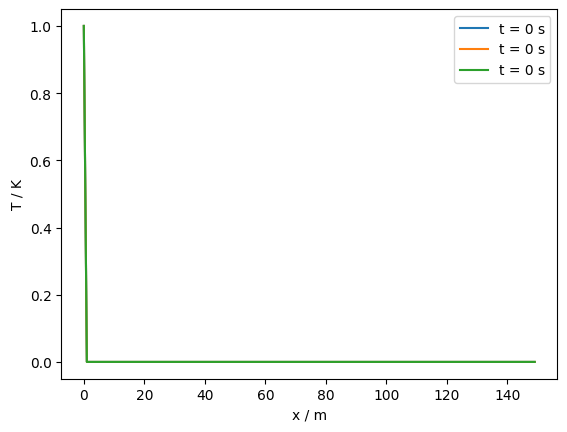

In [15]:
timesteps = [1,2,3]
for it in timesteps:
    plt.plot(sol.solution[it,:], label=f"t = {dt*it} s")
plt.legend()
plt.xlabel("x / m")
plt.ylabel("T / K")